In [2]:
!pip install keras-tuner tensorflow --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
df = pd.read_csv("/content/Ripple_cleaned.csv")

In [5]:
# Check unique values in the Timestamp column
unique_timestamps = df['Timestamp'].unique()[:10]  # Show first 10 for inspection
unique_timestamps

array(['2023-08-03 00:00:00', '2023-09-03 00:00:00',
       '2023-10-03 00:00:00', '2023-11-03 00:00:00',
       '2023-12-03 00:00:00', '13/03/2023', '14/03/2023', '15/03/2023',
       '16/03/2023', '17/03/2023'], dtype=object)

In [6]:
df.shape

(707, 25)

In [7]:
crypto = "Ripple"

In [8]:
# Selecting relevant columns for LSTM
features = ['Open', 'High', 'Low', 'Volume', 'VWAP', 'Volatility', 'Price_Change', 'RSI', 'MACD',
            'MA_7', 'MA_14', 'EMA_7', 'EMA_14', 'Rolling_Std_7', 'Rolling_Std_14',
            'Day_of_Week', 'Month', 'Week_of_Year', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']
target = 'Close'

In [9]:
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto']).dropna()

In [10]:
crypto_df.shape

(707, 24)

In [11]:
crypto_df.isnull().sum()

,0
Timestamp,0
Open,0
High,0
Low,0
Close,0
VWAP,0
Volume,0
Count,0
Volatility,0
Price_Change,0


In [12]:
crypto_df.head()

,Timestamp,Open,High,Low,Close,VWAP,Volume,Count,Volatility,Price_Change,...,Close_Lag_2,Close_Lag_3,Rolling_Std_7,Rolling_Std_14,EMA_7,EMA_14,MACD,Day_of_Week,Month,Week_of_Year
0,2023-08-03 00:00:00,0.38013,0.40117,0.37248,0.38899,0.38978,1.070000e+07,3699,0.02869,0.00884,...,0.37024,0.36686,0.007204,0.006003,0.378871,0.379400,-0.000529,2,3,10
1,2023-09-03 00:00:00,0.38893,0.39717,0.36411,0.37122,0.38414,8.709472e+06,3610,0.03306,-0.01777,...,0.38015,0.37024,0.007433,0.005522,0.376959,0.378310,-0.001351,3,3,10
2,2023-10-03 00:00:00,0.37068,0.37468,0.35744,0.37115,0.36815,6.642818e+06,2358,0.01724,-0.00007,...,0.38899,0.38015,0.007541,0.005723,0.375506,0.377355,-0.001849,4,3,10
3,2023-11-03 00:00:00,0.37106,0.37718,0.36092,0.36655,0.36678,1.420000e+07,6998,0.01626,-0.00460,...,0.37122,0.38899,0.008143,0.006291,0.373267,0.375914,-0.002647,5,3,10
4,2023-12-03 00:00:00,0.36694,0.37400,0.35182,0.37393,0.36368,1.110000e+07,4486,0.02218,0.00738,...,0.37115,0.37122,0.007588,0.006274,0.373433,0.375650,-0.002217,6,3,10


In [13]:
# 🚀 Drop Remaining Rows with Missing Values
df.dropna(inplace=True)

# ✅ Verify all missing values are gone
print(df.isnull().sum())  # Should print all zeros

# ✅ Check dataset size after dropping rows
print(f"Dataset size after dropping missing values: {crypto_df.shape}")

Timestamp         0
Open              0
High              0
Low               0
Close             0
VWAP              0
Volume            0
Count             0
Crypto            0
Volatility        0
Price_Change      0
RSI               0
MA_7              0
MA_14             0
Close_Lag_1       0
Close_Lag_2       0
Close_Lag_3       0
Rolling_Std_7     0
Rolling_Std_14    0
EMA_7             0
EMA_14            0
MACD              0
Day_of_Week       0
Month             0
Week_of_Year      0
dtype: int64
Dataset size after dropping missing values: (707, 24)


In [14]:
cleaned_csv_path = "/content/Ripple_cleaned.csv"
crypto_df.to_csv(cleaned_csv_path, index=False)

# Confirm file saved
print(f"Cleaned dataset saved at: {cleaned_csv_path}")

Cleaned dataset saved at: /content/Ripple_cleaned.csv


In [15]:
df = pd.read_csv("/content/Ripple_cleaned.csv")

In [16]:
df = df.sort_values(by=['Timestamp'])

In [17]:
import plotly.express as px

fig = px.line(df, x=df['Timestamp'], y=df['Close'], labels={'Timestamp': 'Date', 'Close': 'Close Price'})


# Update trace settings
fig.update_traces(
    marker_line_width=2,
    opacity=0.8,
    marker_line_color='orange'
)

# Update layout with title and styling
fig.update_layout(
    title_text='Whole period of timeframe of Ripple close price ',
    plot_bgcolor='white',
    font_size=15,
    font_color='black'
)

# Remove grid from x and y axes
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Show plot
fig.show()

In [18]:
# Normalize data using MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
crypto_scaled_features = scaler_features.fit_transform(crypto_df[features])
target_scaled = scaler_target.fit_transform(crypto_df[[target]])

In [19]:
# Combine after scaling
crypto_scaled = np.hstack((crypto_scaled_features, target_scaled))
crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

In [20]:
# Train-Test Split
train_size = int(len(crypto_scaled) * 0.8)
train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

In [21]:
# Dynamic Sequence Length Tuning
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data.iloc[i-seq_length:i][features].values)
        y_data.append(data.iloc[i][target])
    return np.array(x_data), np.array(y_data)

In [22]:
# Define Model for Keras Tuner
def build_model(hp):
    sequence_length = hp.Int('sequence_length', min_value=5, max_value=30, step=5)

    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        Bidirectional(LSTM(hp.Int('units_1', min_value=64, max_value=512, step=64), return_sequences=True)),
        Dropout(hp.Float('dropout_1', 0.005, 0.02, step=0.005)),

        LSTM(hp.Int('units_2', min_value=64, max_value=512, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_2', 0.005, 0.02, step=0.005)),

        LSTM(hp.Int('units_3', min_value=64, max_value=512, step=64), return_sequences=False),
        Dropout(hp.Float('dropout_3', 0.005, 0.02, step=0.005)),

        Dense(hp.Int('dense_units', 32, 128, step=32), activation='tanh'),
        Dense(1, activation='linear')
    ])

    # Choose loss function dynamically
    loss_fn = hp.Choice('loss_function', ['mse', 'huber'])

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.002, 0.003])),
                  loss=MeanSquaredError() if loss_fn == 'mse' else Huber(delta=2))  # Huber Loss adjusted for Litecoin
    return model

In [23]:
# Setup Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,  # Increase trials for better optimization
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name=f'crypto_forecasting_{crypto}',
    overwrite=True
)

In [31]:
# Run Hyperparameter Tuning
x_train, y_train = create_sequences(train, 10)  # Temporary value, will be optimized
x_test, y_test = create_sequences(test, 10)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

In [33]:
# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_sequence_length = best_hps.get('sequence_length')

In [34]:
# Train Final Model with Best Sequence Length
x_train, y_train = create_sequences(train, optimal_sequence_length)
x_test, y_test = create_sequences(test, optimal_sequence_length)

model = build_model(best_hps)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 665ms/step - loss: 0.0081 - val_loss: 0.1198
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - loss: 3.5511e-04 - val_loss: 0.1063
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 696ms/step - loss: 1.6575e-04 - val_loss: 0.0777
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 603ms/step - loss: 1.0578e-04 - val_loss: 0.0459
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 618ms/step - loss: 9.5650e-05 - val_loss: 0.0319
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 612ms/step - loss: 9.4206e-05 - val_loss: 0.0256
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 599ms/step - loss: 1.0143e-04 - val_loss: 0.0244
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 621ms/step - loss: 1.0144e-04 - val_loss: 0.0278
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 622ms/step - loss: 6.9383e-05 - val_loss: 0.0263
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 597ms/step - loss: 7.6305e-05 - val_loss: 0.0223
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 622ms/step - loss: 8.7222e-05 - val_loss: 0.0243
E

In [35]:
# Predict
y_pred = model.predict(x_test)

# Inverse transform target values
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Calculate Metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"\n📊 Final Model Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step

📊 Final Model Evaluation:
MAE:  0.2807
RMSE: 0.3694
R²:   0.8356


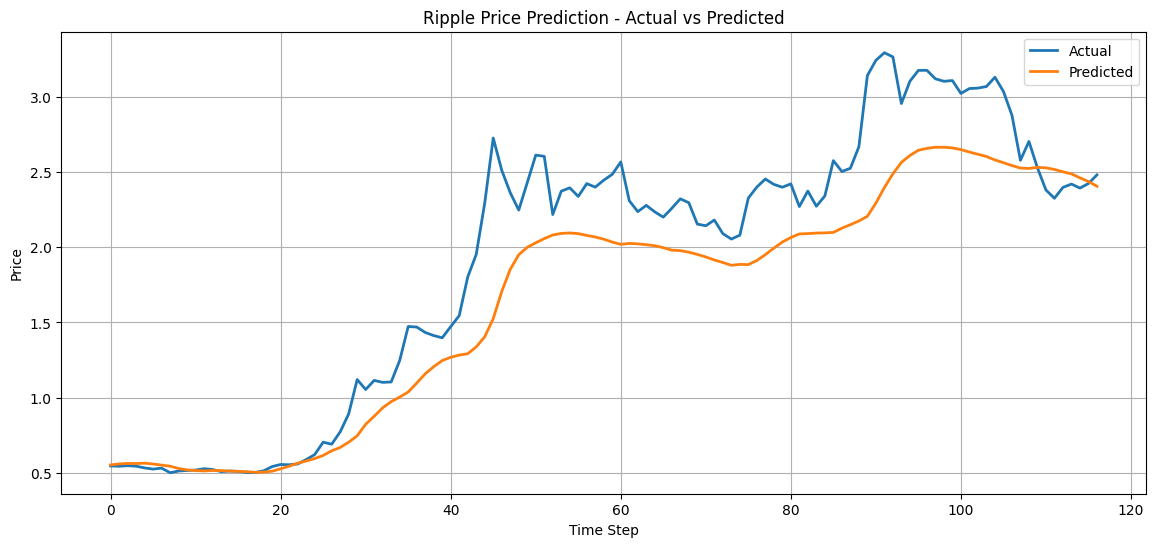

In [38]:
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual', linewidth=2)
plt.plot(y_pred_inv, label='Predicted', linewidth=2)
plt.title(f"{crypto} Price Prediction - Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [40]:
# Step 1: Residual Model (LSTM + LSTM)
# This code assumes you've already trained your initial model and have x_test, y_test, y_pred, and scaler_target in memory.

# Compute residuals
residuals = y_test.reshape(-1, 1) - y_pred  # residual = actual - predicted

# Define a simple LSTM model to learn residuals
def build_residual_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train on the same x_test (sequence data), with residuals as targets
residual_model = build_residual_lstm(x_test.shape[1:])

# Train residual model
residual_model.fit(x_test, residuals, epochs=20, batch_size=32, verbose=1, validation_split=0.2)

# Predict residuals and combine
residual_preds = residual_model.predict(x_test)
final_preds = y_pred + residual_preds

# Inverse scale predictions and evaluate
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
final_preds_inv = scaler_target.inverse_transform(final_preds)

mae = mean_absolute_error(y_test_inv, final_preds_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, final_preds_inv))
r2 = r2_score(y_test_inv, final_preds_inv)

# Results
print(f"\n📊 Final Hybrid (LSTM + Residual LSTM) Model Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")



Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 337ms/step - loss: 0.0720 - val_loss: 0.1250
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0504 - val_loss: 0.0067
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0239 - val_loss: 0.0066
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0148 - val_loss: 0.0184
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0105 - val_loss: 0.0388
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0099 - val_loss: 0.0237
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0070 - val_loss: 0.0106
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0066 - val_loss: 0.0079
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0062 - val_loss: 0.0120
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0073 - val_loss: 0.0236
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0053 - val_loss: 0.0340
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0044 - val_loss: 0.0326

<ipython-input-41-53b3648d6d13>:11: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



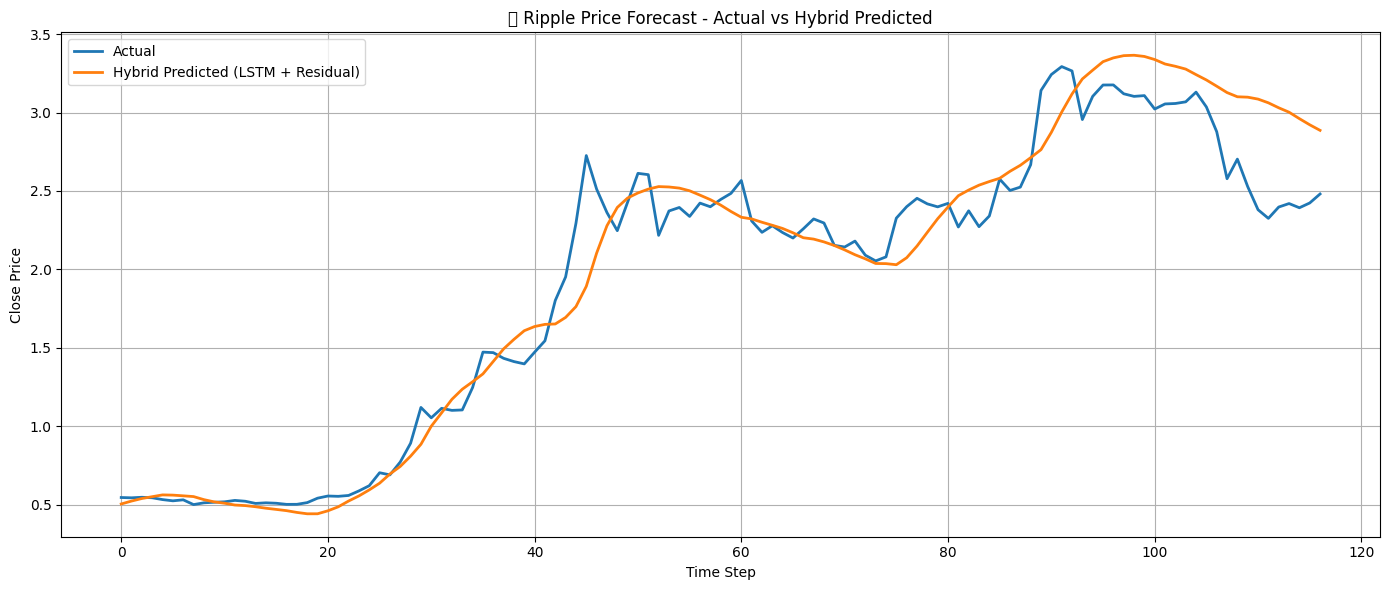

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Actual', linewidth=2)
plt.plot(final_preds_inv, label='Hybrid Predicted (LSTM + Residual)', linewidth=2)
plt.title('📊 Ripple Price Forecast - Actual vs Hybrid Predicted')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



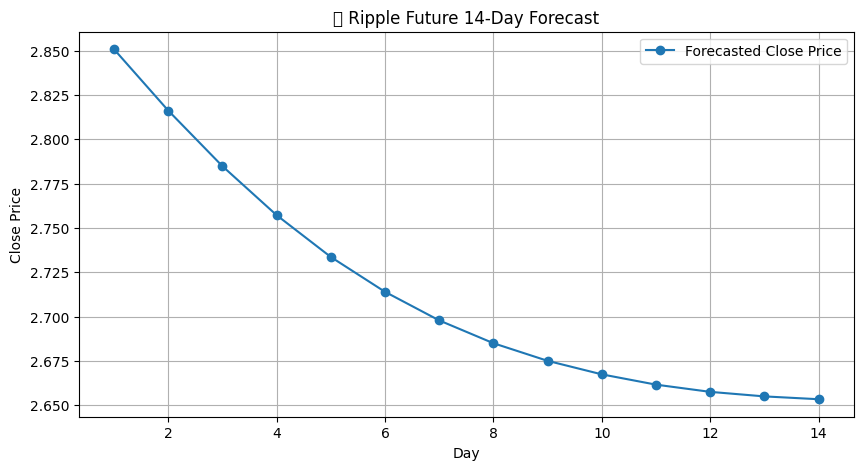

In [42]:
def forecast_future_days(base_model, residual_model, data_df, scaler_features, scaler_target,
                         sequence_length, features, days_ahead=14):
    """
    Generate future price forecasts using trained base and residual LSTM models.
    """
    predictions = []

    # Copy the last N rows from the original scaled data
    last_sequence = data_df[features].values[-sequence_length:]

    for _ in range(days_ahead):
        # Prepare shape: (1, sequence_length, num_features)
        input_seq = np.expand_dims(last_sequence, axis=0)

        # Predict base model
        base_pred = base_model.predict(input_seq, verbose=0)

        # Predict residual
        residual_pred = residual_model.predict(input_seq, verbose=0)

        # Combine predictions
        final_pred_scaled = base_pred + residual_pred

        # Inverse transform to actual price
        final_pred = scaler_target.inverse_transform(final_pred_scaled)[0][0]
        predictions.append(final_pred)

        # Create next row with predicted Close (we'll fill other features with previous values)
        next_row = last_sequence[-1].copy()
        new_row = np.append(next_row[:-1], final_pred_scaled[0])  # Replace Close with predicted scaled value

        # Append new_row and shift window
        last_sequence = np.vstack([last_sequence[1:], new_row])

    return predictions

# Run it
future_days = 14
future_preds = forecast_future_days(
    base_model=model,
    residual_model=residual_model,
    data_df=crypto_scaled,
    scaler_features=scaler_features,
    scaler_target=scaler_target,
    sequence_length=optimal_sequence_length,
    features=features,
    days_ahead=future_days
)

# 📈 Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, future_days + 1), future_preds, marker='o', label='Forecasted Close Price')
plt.title(f'📈 Ripple Future {future_days}-Day Forecast')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()


<ipython-input-43-6943909b4386>:30: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

<ipython-input-43-6943909b4386>:30: UserWarning:

Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.

<ipython-input-43-6943909b4386>:30: UserWarning:

Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.

<ipython-input-43-6943909b4386>:30: UserWarning:

Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) Dej

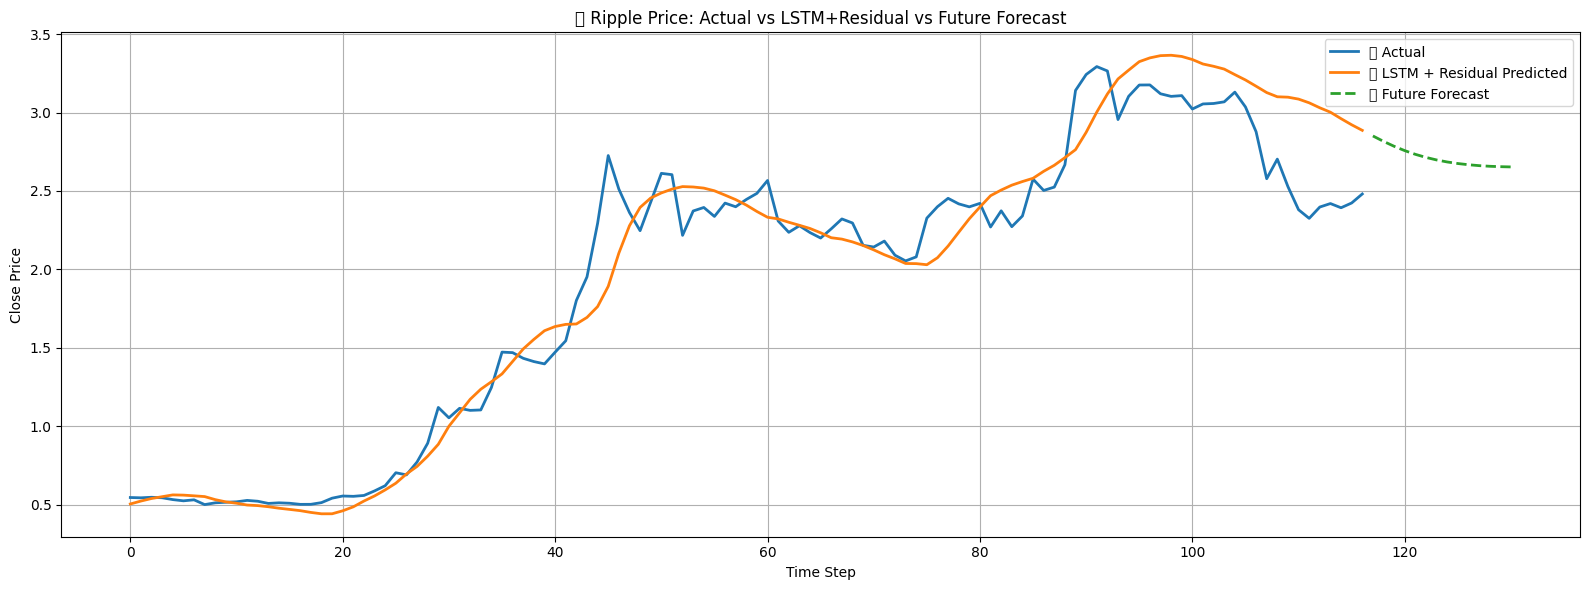

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Step counts
n_test = len(y_test_inv)
n_forecast = len(future_preds)

# Extend x-axis
x_actual = np.arange(n_test)
x_forecast = np.arange(n_test, n_test + n_forecast)

# Plot all
plt.figure(figsize=(16, 6))

# Actual
plt.plot(x_actual, y_test_inv, label='📌 Actual', linewidth=2)

# Hybrid Predicted
plt.plot(x_actual, final_preds_inv, label='🔁 LSTM + Residual Predicted', linewidth=2)

# Future Forecast
plt.plot(x_forecast, future_preds, label='🔮 Future Forecast', linewidth=2, linestyle='dashed')

# Styling
plt.title('📈 Ripple Price: Actual vs LSTM+Residual vs Future Forecast')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
import os

os.makedirs("models", exist_ok=True)
model.save("models/LSTM_Ripple_Base.h5")
residual_model.save("models/LSTM_Ripple_Residual.h5")

print("✅ Models saved as:")
print(" - models/LSTM_Ripple_Base.h5")
print(" - models/LSTM_Ripple_Residual.h5")


✅ Models saved as:
 - models/LSTM_Ripple_Base.h5
 - models/LSTM_Ripple_Residual.h5


In [47]:
from google.colab import files
files.download("models/LSTM_Ripple_Base.h5")
files.download("models/LSTM_Ripple_Residual.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
import joblib

joblib.dump(scaler_features, "models/scaler_features_Ripple.pkl")
joblib.dump(scaler_target, "models/scaler_target_Ripple.pkl")

# Download
files.download("models/scaler_features_Ripple.pkl")
files.download("models/scaler_target_Ripple.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>